In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**UNET + SEGNET**

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 10
image_folder = '/content/drive/MyDrive/customimages'
mask_folder = '/content/drive/MyDrive/custommasks'
# Load your pre-trained models
unet_model = load_model('/content/drive/MyDrive/unetfinal_newcustom.h5')
segnet_model = load_model('/content/drive/MyDrive/segnet_newcustom.h5')
#dlv3_model = load_model('/content/drive/MyDrive/deeplabv3plus_newcustom.h5')
# Create an ensemble model
models = [unet_model, segnet_model]
model_input = Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model2 = Model(inputs=model_input, outputs=ensemble_output, name='ensemble2')
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_folder, batch_size, target_size):
        self.image_filenames = image_filenames
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Construct mask filenames based on image filenames
        batch_y = ['pp_' + os.path.basename(file_name)[:-4] + '_mask.jpg' for file_name in batch_x]
        batch_y = [os.path.join(self.mask_folder, mask_name) for mask_name in batch_y]

        return np.array([
            img_to_array(load_img(file_name, target_size=self.target_size)) for file_name in batch_x])/255., np.array([
            img_to_array(load_img(mask_file, color_mode="grayscale", target_size=self.target_size)) for mask_file in batch_y])/255.

    def get_all_labels(self):
        all_labels = []
        for i in range(self.__len__()):
            _, labels = self.__getitem__(i)
            for label in labels:
                all_labels.append(label)
        return np.array(all_labels)


# Prepare file names for the generator
image_filenames = [fname for fname in os.listdir(image_folder)]
image_full_paths = [os.path.join(image_folder, fname) for fname in image_filenames]

# Split dataset into training and validation
train_images, val_images = train_test_split(image_full_paths, test_size=0.1, random_state=42)

# Create data generators
train_gen = CustomDataGen(train_images, mask_folder, BATCH_SIZE, IMAGE_SIZE)
val_gen = CustomDataGen(val_images, mask_folder, BATCH_SIZE, IMAGE_SIZE)

In [4]:
ensemble_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Consider using a segmentation-specific metric

ensemble_history2 = ensemble_model2.fit(train_gen, epochs=8, validation_data=val_gen)

Epoch 1/8
  1/156 [..............................] - ETA: 4:42:15 - loss: 0.3109 - accuracy: 0.7535

KeyboardInterrupt: ignored

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 43ms/step


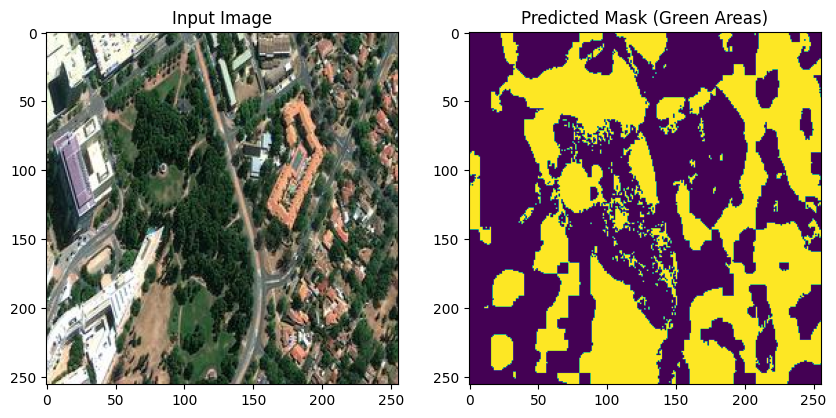

In [7]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the trained model

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
# Load the input image from your Google Drive
#input_image_path = '/content/drive/MyDrive/images/3484_sat_61.jpg'  # Replace with your input image's file path
input_image_path = '/content/drive/MyDrive/Sowmik Dataset/Planned_way/Park all processed data/Preprocessed park/Geleb park-2005.jpg'  # Replace with your input image's file path
input_image = imread(input_image_path)[:, :, :3]  # Assuming 3 channels (RGB)
#input_image = resize(input_image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#input_image = input_image / 255.0  # Normalize the image

# Reshape the input image for prediction
input_image = np.expand_dims(input_image, axis=0)

# Predict green areas in the input image
predictions = ensemble_model2.predict(input_image)

# Threshold the predictions to obtain binary masks
#predicted_mask = (predictions > 0.8).astype(np.uint8)
predicted_mask = (predictions > 0.5).astype(np.uint8)

# Display the input image and the predicted mask (green areas)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(resize(predicted_mask[0, ..., 0], (input_image.shape[1], input_image.shape[2]), mode='constant'), cmap='viridis')
plt.title("Predicted Mask (Green Areas)")
plt.show()


In [8]:
# Assuming you have these folders for test images and masks
test_image_folder = '/content/drive/MyDrive/customimages'
test_mask_folder = '/content/drive/MyDrive/custommasks'

# Prepare file names for the test generator
test_image_filenames = [fname for fname in os.listdir(test_image_folder) if fname.endswith(('.png', '.jpg', '.jpeg'))]  # Make sure to filter only image files
test_image_full_paths = [os.path.join(test_image_folder, fname) for fname in test_image_filenames]

# Create data generator for testing
test_gen = CustomDataGen(test_image_full_paths, test_mask_folder, BATCH_SIZE, IMAGE_SIZE)


In [16]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
import numpy as np

# Making predictions on the test set
predictions = ensemble_model2.predict(test_gen)

# Thresholding predictions to convert them to binary format
thresholded_preds = (predictions > 0.5).astype(np.uint8)

# Flatten the predictions
flat_predictions = thresholded_preds.flatten()

# Retrieve and process true labels
flat_true_labels = []
for i in range(len(test_gen)):
    _, labels = test_gen[i]  # Retrieve batch of labels
    for label in labels:
        flat_true_labels.extend(label.flatten())  # Flatten and append each label

flat_true_labels = np.array(flat_true_labels)

# Ensure binary format for true labels
binary_true_labels = (flat_true_labels > 0.5).astype(np.uint8)

# Check if there are any positive predictions
positive_predictions = np.sum(flat_predictions)
print(f"Number of positive predictions: {positive_predictions}")

# Set zero_division parameter based on your preference
zero_division_parameter = 0 if positive_predictions > 0 else 1

# Calculate the metrics with adjusted precision calculation
accuracy = accuracy_score(binary_true_labels, flat_predictions)
precision = precision_score(binary_true_labels, flat_predictions, zero_division=zero_division_parameter)
f1 = f1_score(binary_true_labels, flat_predictions)

print(f"Accuracy: {accuracy}, Precision: {precision}, F1-Score: {f1}")


173/173 [==============================] - 28s 160ms/step
Number of positive predictions: 0
Accuracy: 0.8515060592677873, Precision: 1.0, F1-Score: 0.0


In [1]:
from sklearn.metrics import confusion_matrix, roc_auc_score

# Calculate confusion matrix and ROC AUC
conf_matrix = confusion_matrix(binary_true_labels, flat_predictions)
roc_auc = roc_auc_score(binary_true_labels, flat_predictions)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}, Precision: {precision}, F1-Score: {f1}")


NameError: ignored